In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient
from glob import glob
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

2023-02-11 09:16:45.310563: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-11 09:16:45.310697: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
GCS_DS_PATH = KaggleDatasets().get_gcs_path('website-defacement')

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
N_JOBS = cpu_count()

IMG_SIZE = 224
EPOCHS = 20

print('N_JOBS:', N_JOBS)
print('Batch size:', BATCH_SIZE)
print('GCS_DS_PATH:', GCS_DS_PATH)

Running on TPU: grpc://10.0.0.2:8470


2023-02-11 09:16:51.868991: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-11 09:16:51.871692: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-11 09:16:51.871719: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-11 09:16:51.871743: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f784d0e0d14a): /proc/driver/nvidia/version does not exist
2023-02-11 09:16:51.875081: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

N_JOBS: 4
Batch size: 64
GCS_DS_PATH: gs://kds-49faf06699ed9969fab2373b31133488200b2d328b3f3c02b2338c33


In [3]:
dataset_path = '../input/website-defacement/'
img_paths = glob(dataset_path + 'image/*/*')
txt_paths = glob(dataset_path + 'text/*/*')
img_names = [path.split('/')[-1][:-4] for path in img_paths]
txt_names = [path.split('/')[-1][:-4] for path in txt_paths]
names = list(set(img_names).intersection(txt_names))

In [4]:
def prepare_data(name):
    if glob(dataset_path + f'text/defaced/{name}.txt'):
        path = dataset_path + f'text/defaced/{name}.txt'
        label = 1
    else:
        path = dataset_path + f'text/benign/{name}.txt'
        label = 0
    with open(path, 'r') as f:
        text = f.read()
    return (text, label)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train_txt, X_test_txt, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)

X_train_txt, X_valid_txt, y_train, y_valid = train_test_split(X_train_txt, y_train, test_size=0.25, 
                                                      random_state=42)

  0%|          | 0/96234 [00:00<?, ?it/s]

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train_txt)

MAXLEN = 128

X_train_txt = tokenizer.texts_to_sequences(X_train_txt)
X_train_txt = pad_sequences(X_train_txt, maxlen=MAXLEN)
y_train = np.array(y_train)

X_valid_txt = tokenizer.texts_to_sequences(X_valid_txt)
X_valid_txt = pad_sequences(X_valid_txt, maxlen=MAXLEN)
y_valid = np.array(y_valid)

X_test_txt = tokenizer.texts_to_sequences(X_test_txt)
X_test_txt = pad_sequences(X_test_txt, maxlen=MAXLEN)
y_test = np.array(y_test)

In [6]:
def prepare_data(name):
    if glob(dataset_path + f'image/defaced/{name}.png'):
        return (f'{GCS_DS_PATH}/image/defaced/{name}.png', 1)
    else:
        return (f'{GCS_DS_PATH}/image/benign/{name}.png', 0)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train_img, X_test_img, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_ = to_categorical(y_train_, num_classes=2)
X_train_img, X_valid_img, y_train_, y_valid_ = train_test_split(X_train_img, y_train_, test_size=0.25, 
                                                      random_state=42)
print((y_train == y_train_).all(), (y_valid == y_valid_).all(), (y_test == y_test_).all())

  0%|          | 0/96234 [00:00<?, ?it/s]

True True True


In [7]:
def load_data(text, image_path, label=None):
    bits = tf.io.read_file(image_path)
    image = tf.image.decode_png(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
#     image = tf.reshape(image, (IMG_SIZE, IMG_SIZE, 3))
    
    data = (image, text)
    
    if label is None:
        return image, text
    else:
        return data, label

train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_train_txt, X_train_img, y_train))
    .shuffle(100000)
    .map(load_data, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_test_txt, X_test_img, y_test))
    .map(load_data, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_valid_txt, X_valid_img, y_valid))
    .map(load_data, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

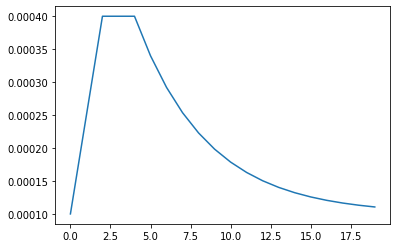

In [8]:
def lrfn(epoch=EPOCHS,
         lr_start=1e-4,
         lr_max=5e-5 * 8, 
         lr_min=1e-4,
         lr_rampup_epochs=2,
         lr_sustain_epochs=2,
         lr_exp_decay=0.8):
    if epoch < lr_rampup_epochs:
        lr = (lr_max-lr_start)/lr_rampup_epochs*epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max-lr_min)*lr_exp_decay**(epoch-lr_rampup_epochs-lr_sustain_epochs) + lr_min
    return lr

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

### CNN

**Text_LSTM**

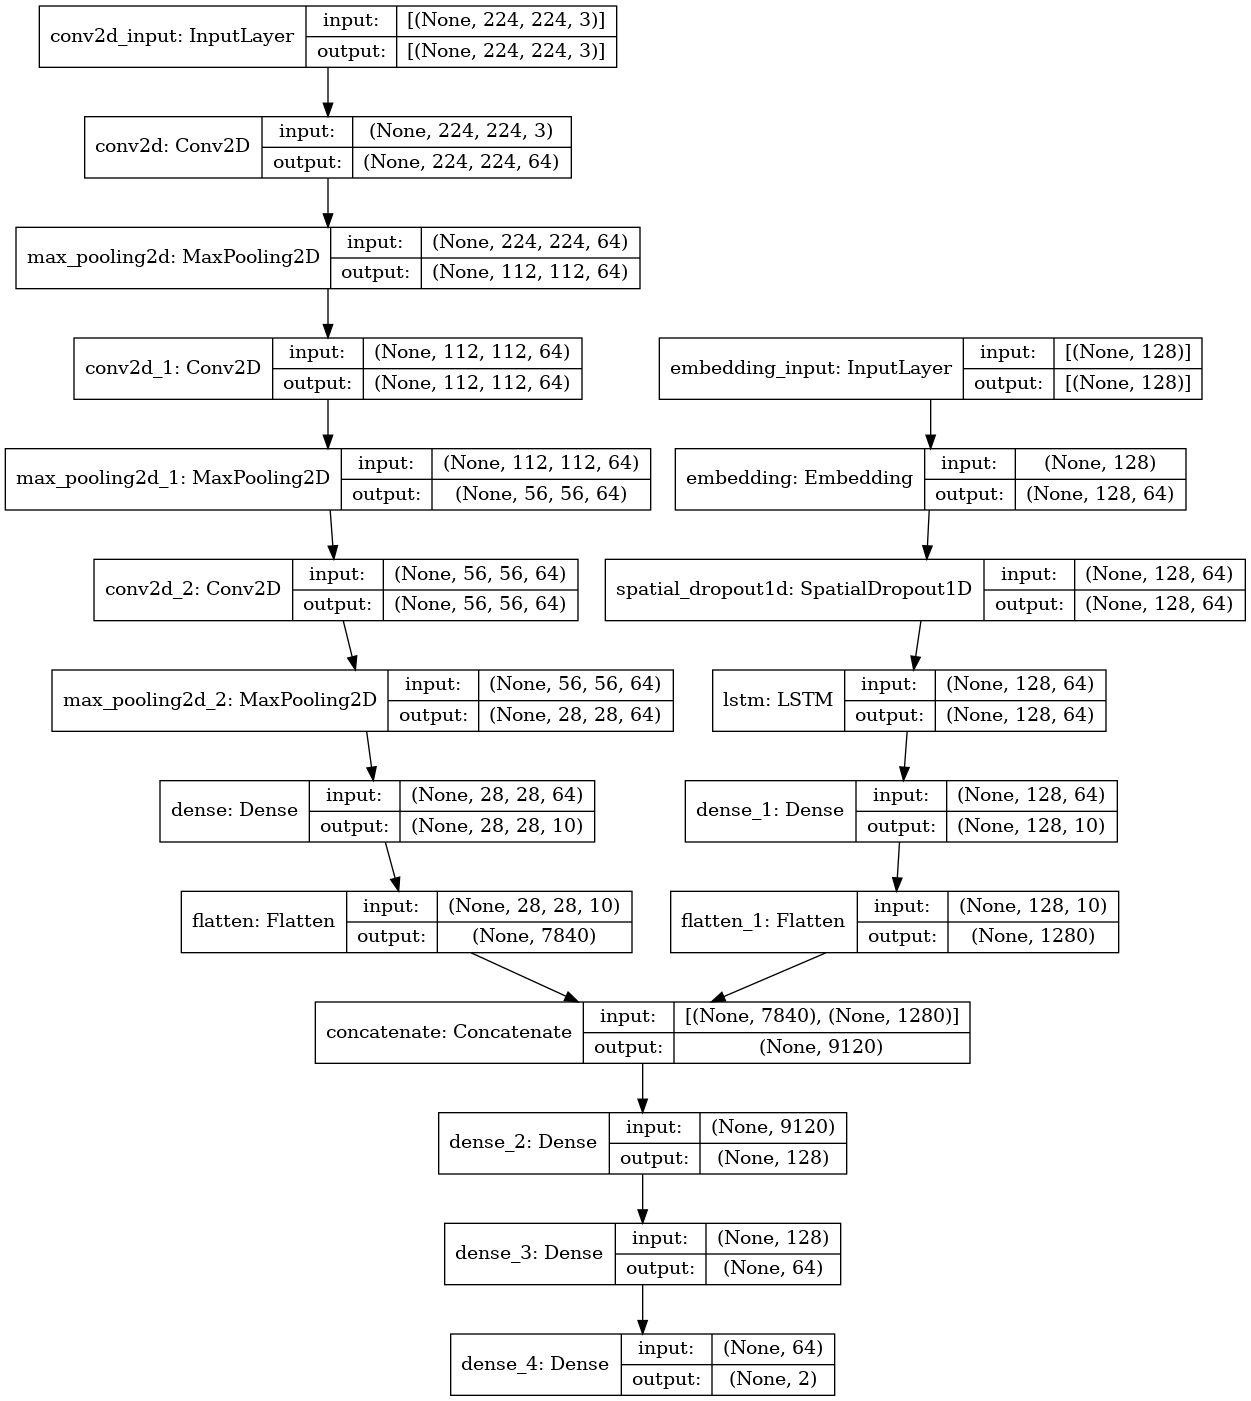

In [9]:
with strategy.scope():
    image_model = Sequential()
    image_model.add(L.Conv2D(64,3,padding="same", input_shape=(IMG_SIZE, IMG_SIZE, 3),activation="relu"))
    image_model.add(L.MaxPooling2D())
    image_model.add(L.Conv2D(64,3,padding="same",activation="relu"))
    image_model.add(L.MaxPooling2D())
    image_model.add((L.Conv2D(64,3,padding="same",activation="relu")))
    image_model.add(L.MaxPooling2D())
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add((L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [10]:
lrs = LearningRateScheduler(lrfn)  
# tf.config.run_functions_eagerly(True)
mc = ModelCheckpoint('image_cnn_weights_lstm.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171541632 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 2214s - loss: 0.1654 - accuracy: 0.9330 - val_loss: 0.0867 - val_accuracy: 0.9681
Epoch 2/20
902/902 - 55s - loss: 0.0310 - accuracy: 0.9898 - val_loss: 0.1061 - val_accuracy: 0.9677
Epoch 3/20
902/902 - 55s - loss: 0.0094 - accuracy: 0.9974 - val_loss: 0.1387 - val_accuracy: 0.9691
Epoch 4/20
902/902 - 55s - loss: 0.0059 - accuracy: 0.9984 - val_loss: 0.1219 - val_accuracy: 0.9699
Epoch 5/20
902/902 - 55s - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.1630 - val_accuracy: 0.9675
Epoch 6/20
902/902 - 55s - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.1705 - val_accuracy: 0.9670
Epoch 7/20
902/902 - 55s - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.1783 - val_accuracy: 0.9680
Epoch 8/20
902/902 - 55s - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.1679 - val_accuracy: 0.9683
Epoch 9/20
902/902 - 55s - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.1731 - val_accuracy: 0.9685
Epoch 10/20
902/902 - 55s - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.1667 - val_accuracy: 0.969

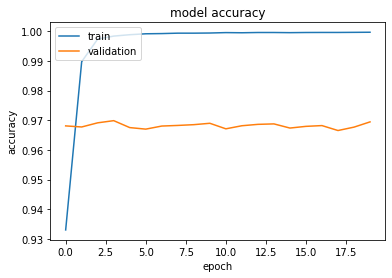

In [11]:
plot_hist(hist)

In [12]:
with strategy.scope():
    model.load_weights('image_cnn_weights_lstm.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 551s 2s/step
              precision    recall  f1-score   support

           0     0.9640    0.9893    0.9765     11443
           1     0.9837    0.9458    0.9644      7804

    accuracy                         0.9717     19247
   macro avg     0.9739    0.9676    0.9704     19247
weighted avg     0.9720    0.9717    0.9716     19247

[[11321   122]
 [  423  7381]]
      TPR       FPR       FNR   ROC AUC
   0.9458    0.0107    0.0542    0.9956


**Text_RNN**

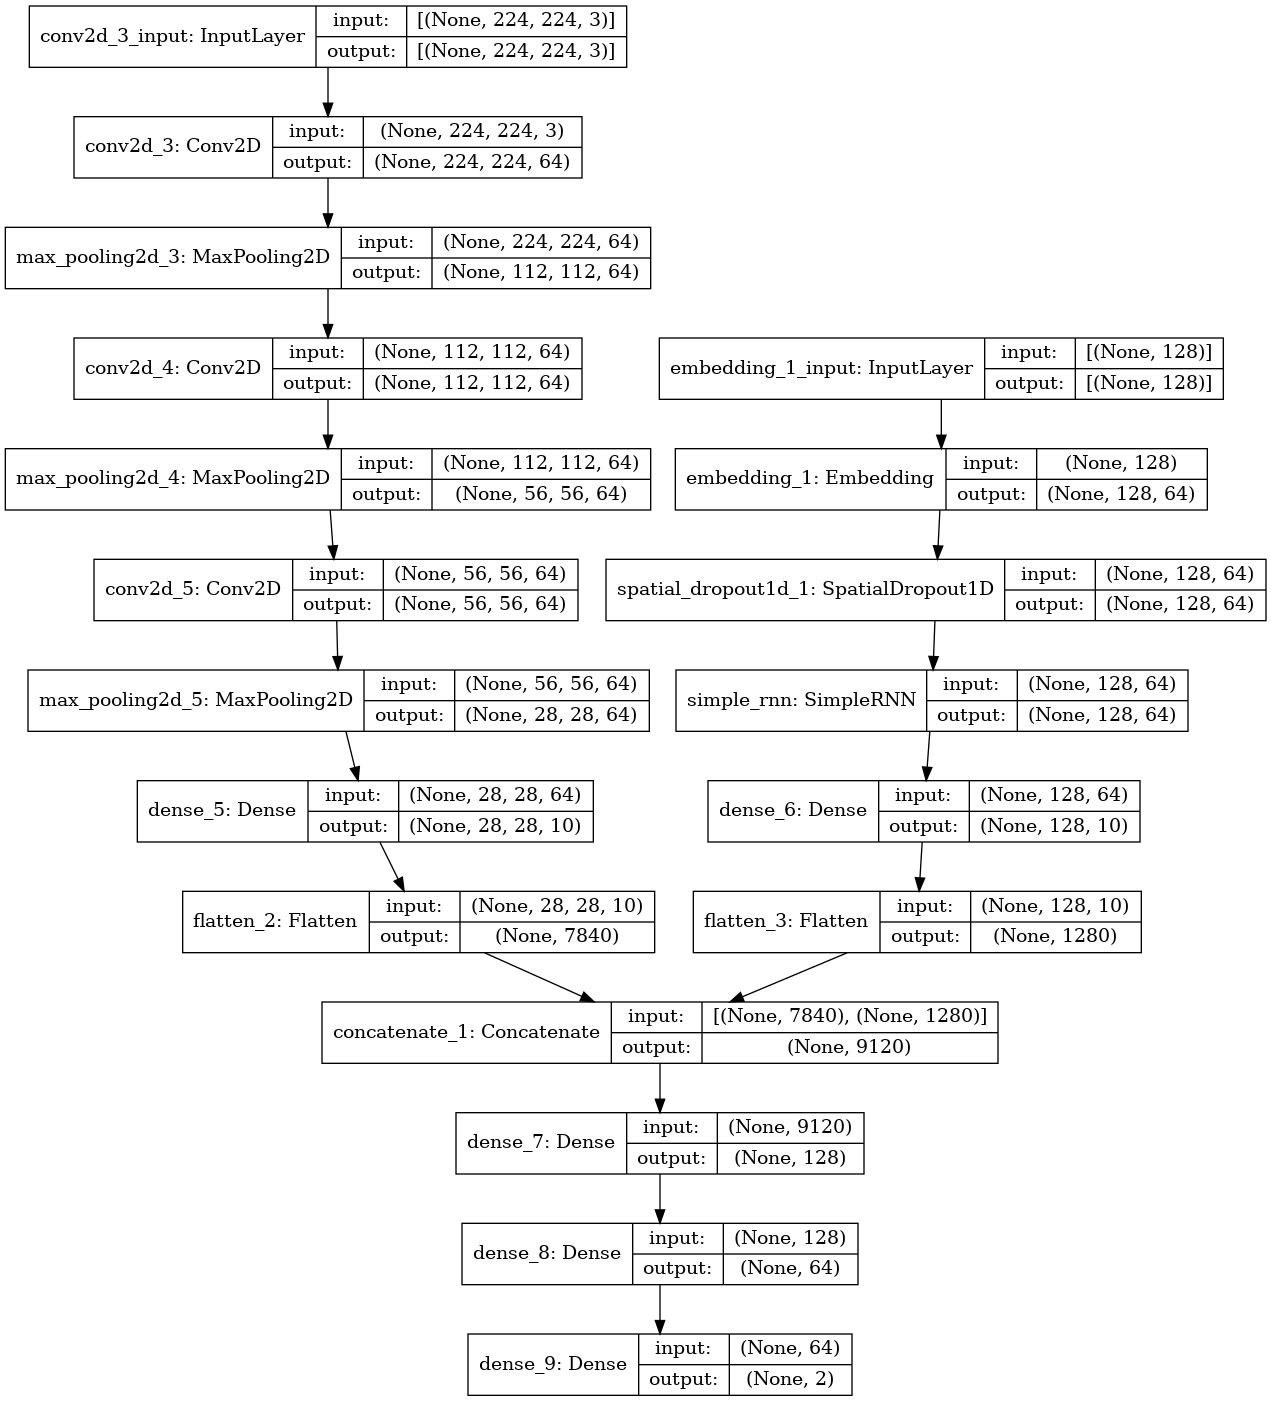

In [13]:
with strategy.scope():
    image_model = Sequential()
    image_model.add(L.Conv2D(64,3,padding="same", input_shape=(IMG_SIZE, IMG_SIZE, 3),activation="relu"))
    image_model.add(L.MaxPooling2D())
    image_model.add(L.Conv2D(64,3,padding="same",activation="relu"))
    image_model.add(L.MaxPooling2D())
    image_model.add((L.Conv2D(64,3,padding="same",activation="relu")))
    image_model.add(L.MaxPooling2D())
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add((L.SimpleRNN(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, unroll=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [14]:
    lrs = LearningRateScheduler(lrfn)  
    # tf.config.run_functions_eagerly(True)
    mc = ModelCheckpoint('image_cnn_weights_rnn.h5', save_best_only=True, save_weights_only=True)
    steps_per_epoch = len(y_train) // BATCH_SIZE

    hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                     callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171541632 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 89s - loss: 0.2992 - accuracy: 0.8627 - val_loss: 0.1140 - val_accuracy: 0.9563
Epoch 2/20
902/902 - 53s - loss: 0.0679 - accuracy: 0.9756 - val_loss: 0.1135 - val_accuracy: 0.9631
Epoch 3/20
902/902 - 53s - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.1346 - val_accuracy: 0.9518
Epoch 4/20
902/902 - 53s - loss: 0.0151 - accuracy: 0.9955 - val_loss: 0.1289 - val_accuracy: 0.9635
Epoch 5/20
902/902 - 52s - loss: 0.0099 - accuracy: 0.9971 - val_loss: 0.1481 - val_accuracy: 0.9612
Epoch 6/20
902/902 - 52s - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.1448 - val_accuracy: 0.9655
Epoch 7/20
902/902 - 52s - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.1498 - val_accuracy: 0.9643
Epoch 8/20
902/902 - 52s - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.1699 - val_accuracy: 0.9515
Epoch 9/20
902/902 - 52s - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.1606 - val_accuracy: 0.9642
Epoch 10/20
902/902 - 52s - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.1685 - val_accuracy: 0.9634


In [15]:
with strategy.scope():
    model.load_weights('image_cnn_weights_rnn.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 415s 1s/step
              precision    recall  f1-score   support

           0     0.9691    0.9811    0.9751     11443
           1     0.9718    0.9541    0.9629      7804

    accuracy                         0.9702     19247
   macro avg     0.9705    0.9676    0.9690     19247
weighted avg     0.9702    0.9702    0.9701     19247

[[11227   216]
 [  358  7446]]
      TPR       FPR       FNR   ROC AUC
   0.9541    0.0189    0.0459    0.9946


**Text_CNN**

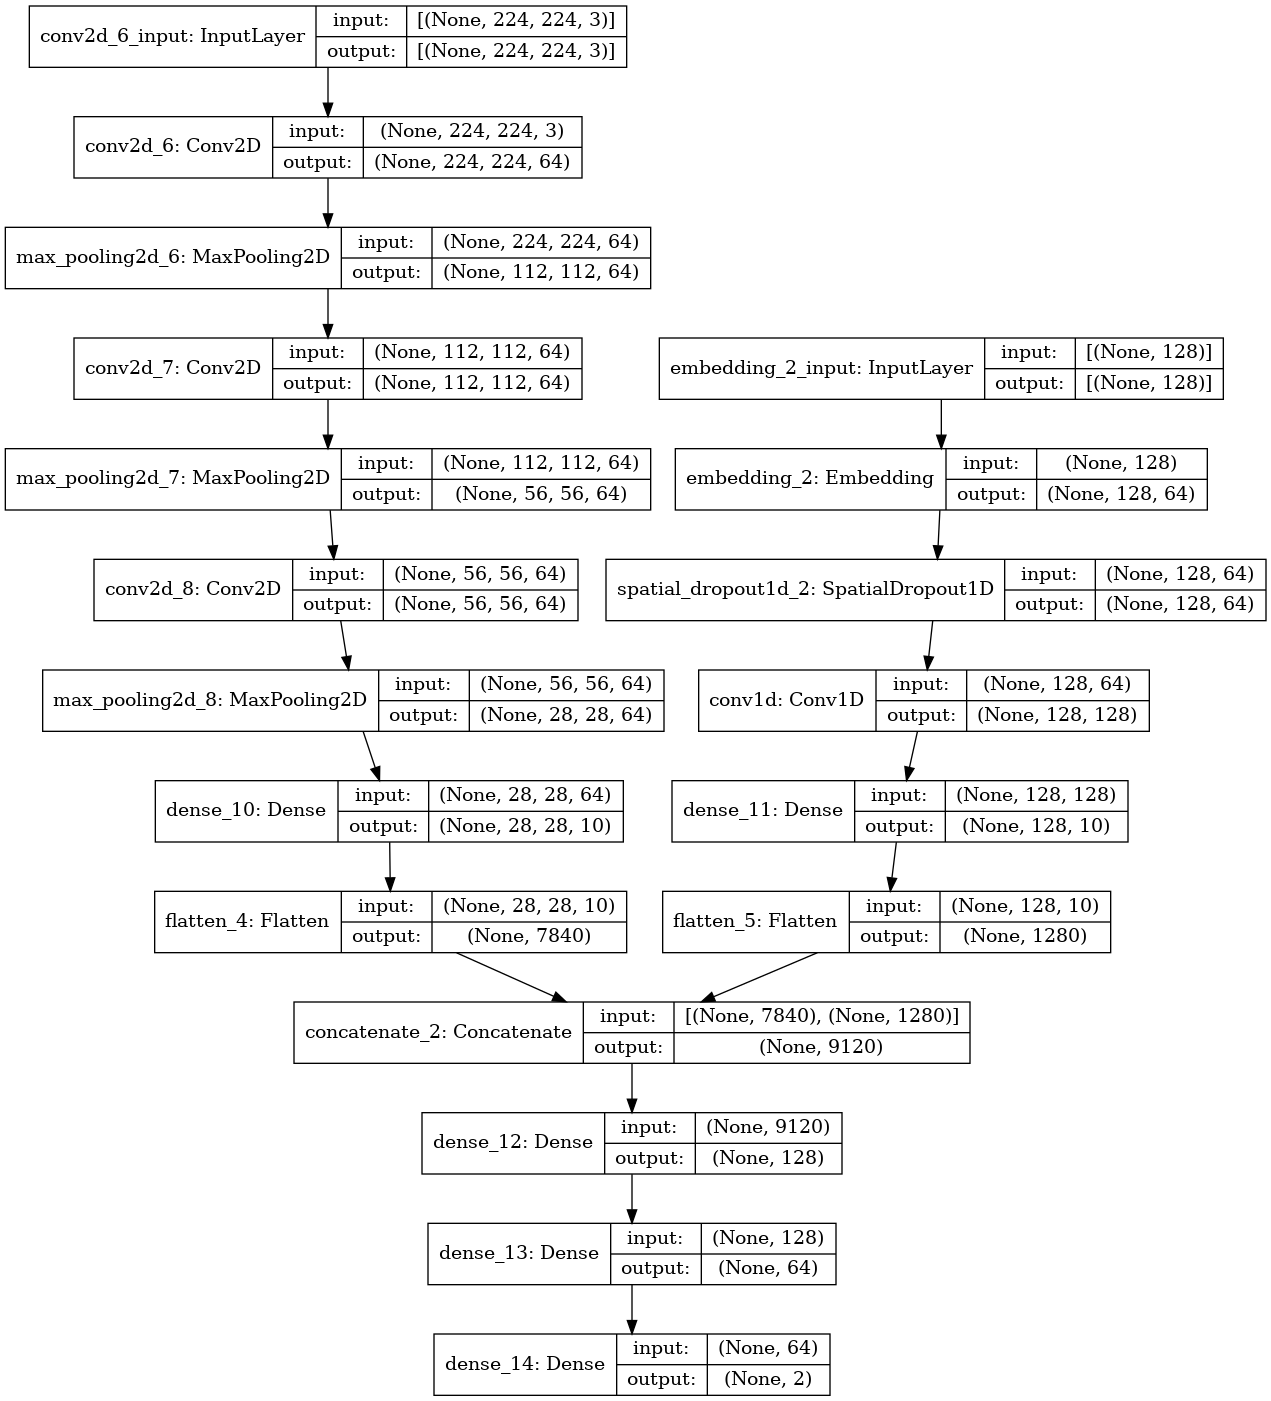

In [16]:
with strategy.scope():
    image_model = Sequential()
    image_model.add(L.Conv2D(64,3,padding="same", input_shape=(IMG_SIZE, IMG_SIZE, 3),activation="relu"))
    image_model.add(L.MaxPooling2D())
    image_model.add(L.Conv2D(64,3,padding="same",activation="relu"))
    image_model.add(L.MaxPooling2D())
    image_model.add((L.Conv2D(64,3,padding="same",activation="relu")))
    image_model.add(L.MaxPooling2D())
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Conv1D(128, 5, padding="same",))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [17]:
    lrs = LearningRateScheduler(lrfn)  
    # tf.config.run_functions_eagerly(True)
    mc = ModelCheckpoint('image_cnn_weights_cnn.h5', save_best_only=True, save_weights_only=True)
    steps_per_epoch = len(y_train) // BATCH_SIZE

    hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                     callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171541632 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 68s - loss: 0.1684 - accuracy: 0.9320 - val_loss: 0.0969 - val_accuracy: 0.9624
Epoch 2/20
902/902 - 51s - loss: 0.0278 - accuracy: 0.9909 - val_loss: 0.1244 - val_accuracy: 0.9549
Epoch 3/20
902/902 - 50s - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.1539 - val_accuracy: 0.9519
Epoch 4/20
902/902 - 52s - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.1720 - val_accuracy: 0.9491
Epoch 5/20
902/902 - 51s - loss: 0.0036 - accuracy: 0.9989 - val_loss: 0.1904 - val_accuracy: 0.9466
Epoch 6/20
902/902 - 51s - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.1905 - val_accuracy: 0.9496
Epoch 7/20
902/902 - 50s - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.1879 - val_accuracy: 0.9599
Epoch 8/20
902/902 - 51s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.2049 - val_accuracy: 0.9585
Epoch 9/20
902/902 - 51s - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.1997 - val_accuracy: 0.9493
Epoch 10/20
902/902 - 51s - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.2003 - val_accuracy: 0.9585


In [18]:
with strategy.scope():
    model.load_weights('image_cnn_weights_cnn.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 450s 1s/step
              precision    recall  f1-score   support

           0     0.9650    0.9776    0.9713     11443
           1     0.9666    0.9480    0.9572      7804

    accuracy                         0.9656     19247
   macro avg     0.9658    0.9628    0.9642     19247
weighted avg     0.9656    0.9656    0.9656     19247

[[11187   256]
 [  406  7398]]
      TPR       FPR       FNR   ROC AUC
   0.9480    0.0224    0.0520    0.9941


### RNN

In [19]:
def load_data(text, image_path, label=None):
    bits = tf.io.read_file(image_path)
    image = tf.image.decode_png(bits, channels=1)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.reshape(image, (IMG_SIZE, IMG_SIZE))
    
    data = (image, text)
    
    if label is None:
        return image, text
    else:
        return data, label

train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_train_txt, X_train_img, y_train))
    .shuffle(100000)
    .map(load_data, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_test_txt, X_test_img, y_test))
    .map(load_data, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_valid_txt, X_valid_img, y_valid))
    .map(load_data, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

**Text_LSTM**

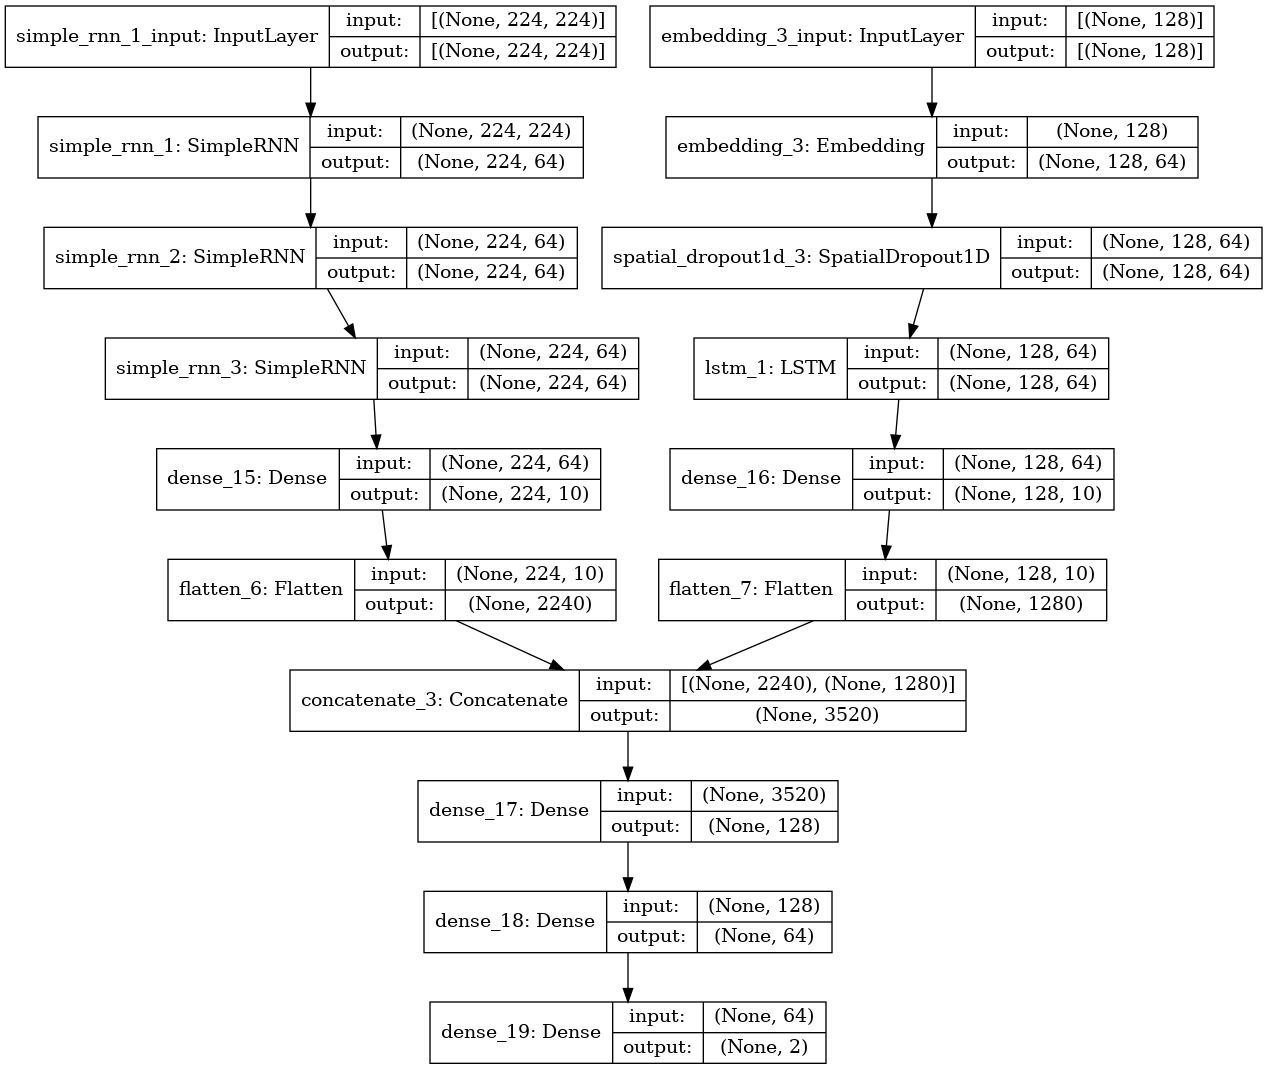

In [20]:
with strategy.scope():
    image_model = Sequential()
    image_model.add(L.SimpleRNN(units=64, return_sequences=True,input_shape=(IMG_SIZE, IMG_SIZE),unroll=True))
    image_model.add((L.SimpleRNN(units=64, return_sequences=True,unroll=True)))
    image_model.add((L.SimpleRNN(units=64,unroll=True, return_sequences=True)))
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add((L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [21]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('image_rnn_weights_lstm.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171541632 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 1751s - loss: 0.1597 - accuracy: 0.9380 - val_loss: 0.0878 - val_accuracy: 0.9685
Epoch 2/20
902/902 - 43s - loss: 0.0315 - accuracy: 0.9892 - val_loss: 0.1016 - val_accuracy: 0.9672
Epoch 3/20
902/902 - 43s - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.1212 - val_accuracy: 0.9688
Epoch 4/20
902/902 - 44s - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.1258 - val_accuracy: 0.9670
Epoch 5/20
902/902 - 43s - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.1550 - val_accuracy: 0.9678
Epoch 6/20
902/902 - 43s - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.1634 - val_accuracy: 0.9678
Epoch 7/20
902/902 - 43s - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.2597 - val_accuracy: 0.9630
Epoch 8/20
902/902 - 43s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1944 - val_accuracy: 0.9683
Epoch 9/20
902/902 - 43s - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.2383 - val_accuracy: 0.9665
Epoch 10/20
902/902 - 43s - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.1886 - val_accuracy: 0.966

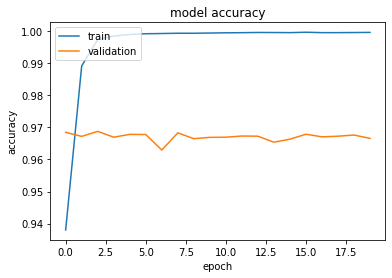

In [22]:
plot_hist(hist)

In [23]:
with strategy.scope():
    model.load_weights('image_rnn_weights_lstm.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 430s 1s/step
              precision    recall  f1-score   support

           0     0.9658    0.9862    0.9759     11443
           1     0.9791    0.9487    0.9637      7804

    accuracy                         0.9710     19247
   macro avg     0.9724    0.9675    0.9698     19247
weighted avg     0.9712    0.9710    0.9709     19247

[[11285   158]
 [  400  7404]]
      TPR       FPR       FNR   ROC AUC
   0.9487    0.0138    0.0513    0.9950


**Text_RNN**

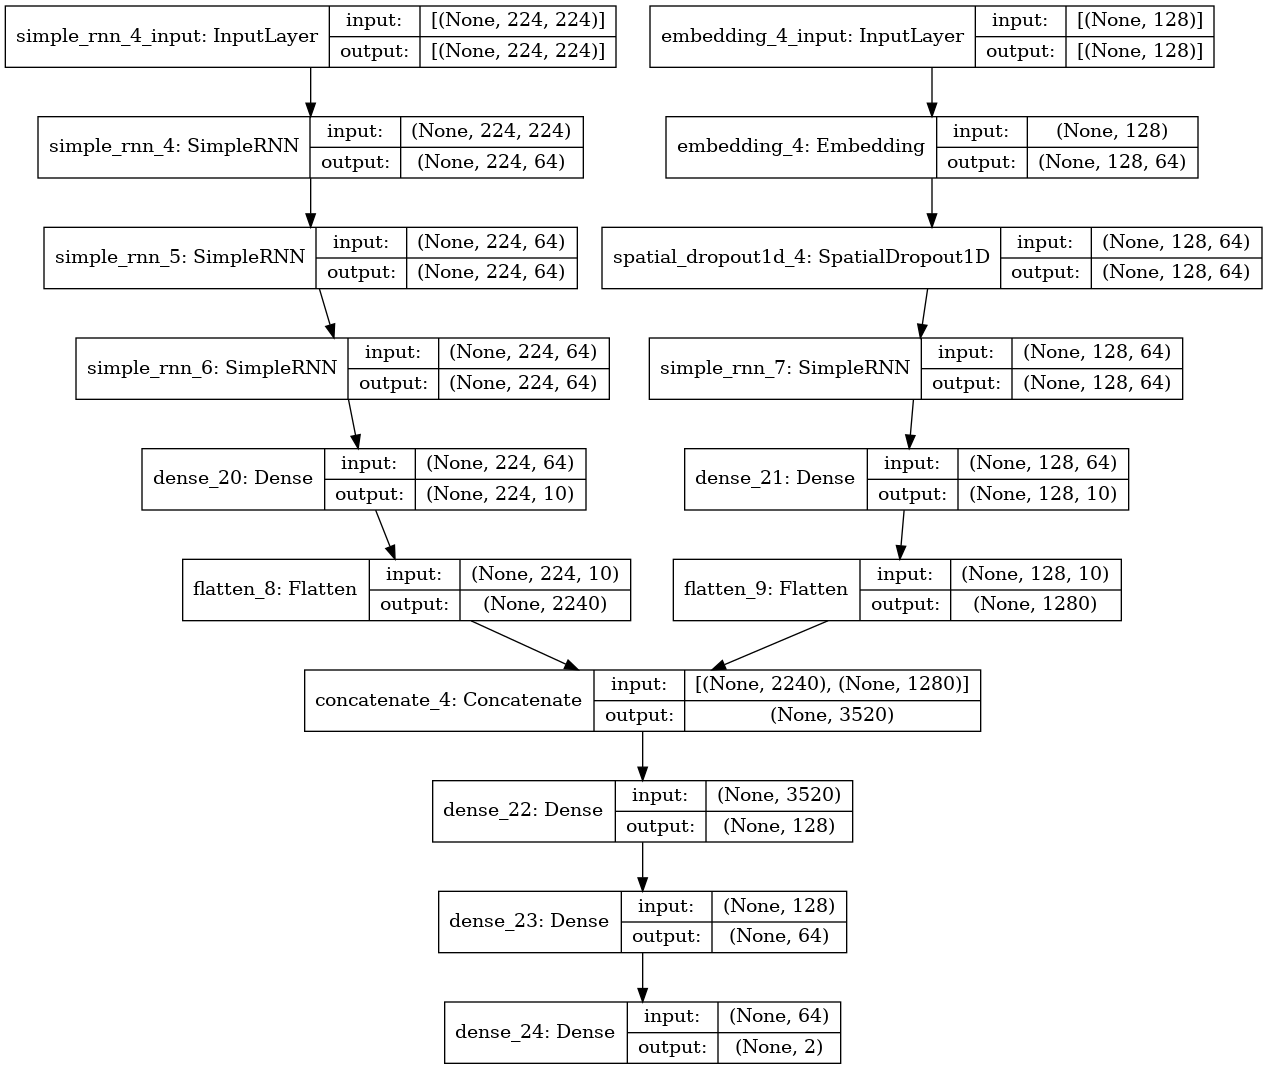

In [24]:
with strategy.scope():
    image_model = Sequential()
    image_model.add(L.SimpleRNN(units=64, return_sequences=True,input_shape=(IMG_SIZE, IMG_SIZE),unroll=True))
    image_model.add((L.SimpleRNN(units=64, return_sequences=True,unroll=True)))
    image_model.add((L.SimpleRNN(units=64,unroll=True, return_sequences=True)))
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add((L.SimpleRNN(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,unroll=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [25]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('image_rnn_weights_rnn.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171541632 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 161s - loss: 0.3468 - accuracy: 0.8423 - val_loss: 0.1505 - val_accuracy: 0.9420
Epoch 2/20
902/902 - 40s - loss: 0.1088 - accuracy: 0.9585 - val_loss: 0.1283 - val_accuracy: 0.9543
Epoch 3/20
902/902 - 40s - loss: 0.0402 - accuracy: 0.9865 - val_loss: 0.1636 - val_accuracy: 0.9505
Epoch 4/20
902/902 - 40s - loss: 0.0216 - accuracy: 0.9931 - val_loss: 0.1640 - val_accuracy: 0.9505
Epoch 5/20
902/902 - 40s - loss: 0.0140 - accuracy: 0.9955 - val_loss: 0.2040 - val_accuracy: 0.9481
Epoch 6/20
902/902 - 40s - loss: 0.0096 - accuracy: 0.9970 - val_loss: 0.2037 - val_accuracy: 0.9526
Epoch 7/20
902/902 - 40s - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.1936 - val_accuracy: 0.9545
Epoch 8/20
902/902 - 40s - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.2600 - val_accuracy: 0.9440
Epoch 9/20
902/902 - 40s - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0.2519 - val_accuracy: 0.9498
Epoch 10/20
902/902 - 40s - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.2265 - val_accuracy: 0.9503

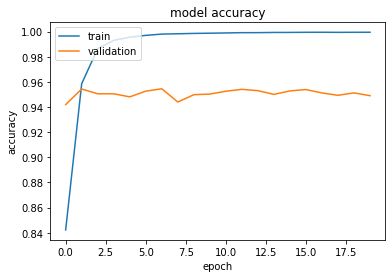

In [26]:
plot_hist(hist)

In [27]:
with strategy.scope():
    model.load_weights('image_rnn_weights_rnn.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 441s 1s/step
              precision    recall  f1-score   support

           0     0.9600    0.9712    0.9656     11443
           1     0.9571    0.9407    0.9488      7804

    accuracy                         0.9589     19247
   macro avg     0.9586    0.9560    0.9572     19247
weighted avg     0.9588    0.9589    0.9588     19247

[[11114   329]
 [  463  7341]]
      TPR       FPR       FNR   ROC AUC
   0.9407    0.0288    0.0593    0.9915


**Text_CNN**

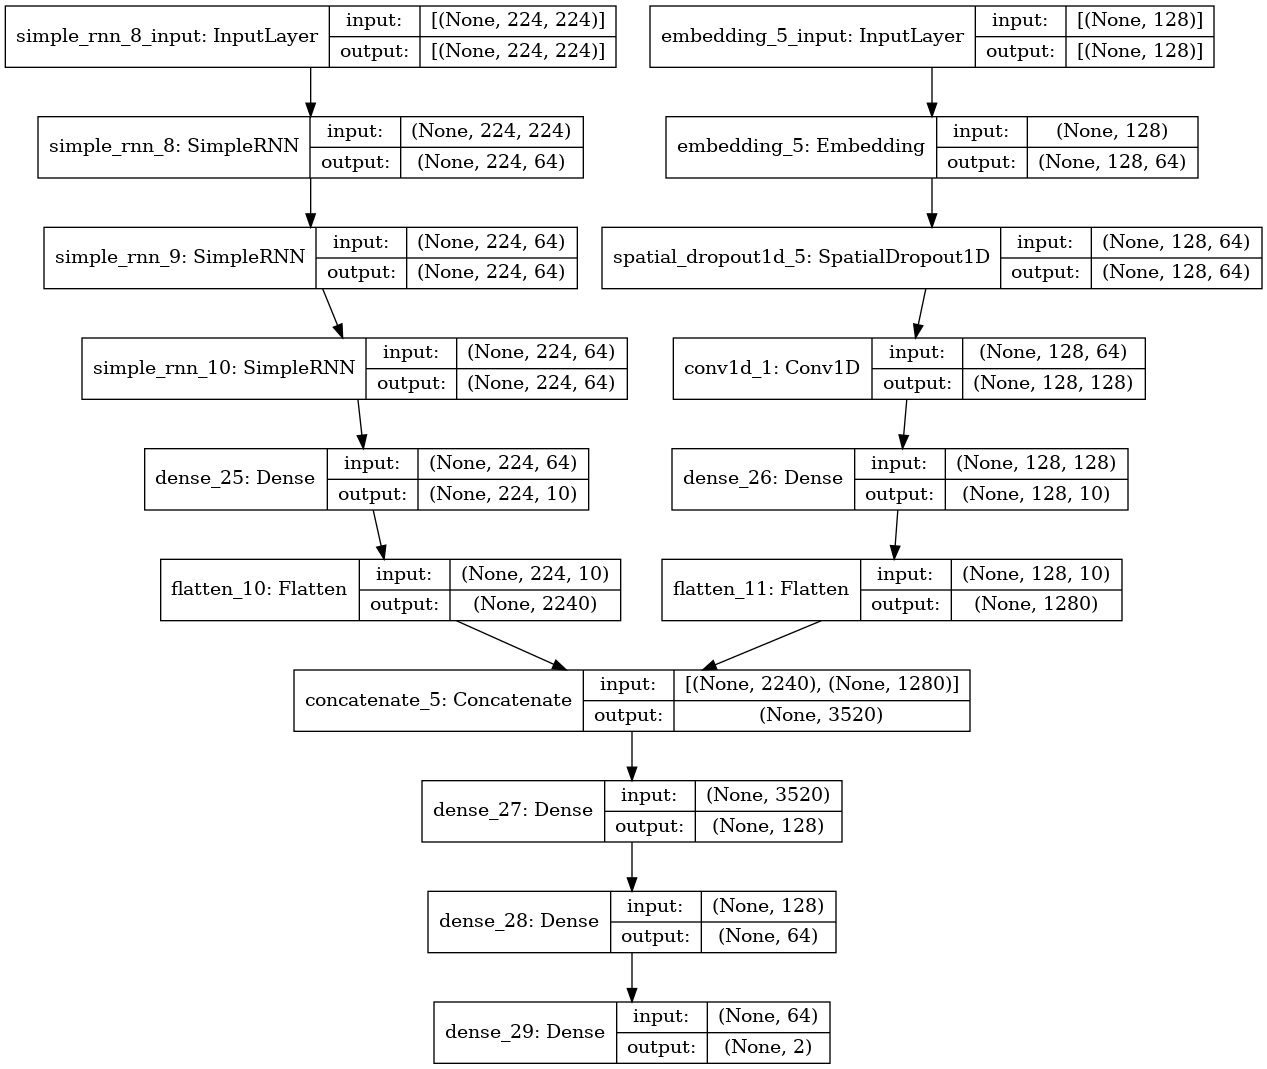

In [28]:
with strategy.scope():
    image_model = Sequential()
    image_model.add(L.SimpleRNN(units=64, return_sequences=True,input_shape=(IMG_SIZE, IMG_SIZE),unroll=True))
    image_model.add((L.SimpleRNN(units=64, return_sequences=True,unroll=True)))
    image_model.add((L.SimpleRNN(units=64,unroll=True, return_sequences=True)))
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Conv1D(128, 5, padding="same"))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [29]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('image_rnn_weights_cnn.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171541632 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 142s - loss: 0.1479 - accuracy: 0.9434 - val_loss: 0.0933 - val_accuracy: 0.9668
Epoch 2/20
902/902 - 39s - loss: 0.0254 - accuracy: 0.9919 - val_loss: 0.1034 - val_accuracy: 0.9677
Epoch 3/20
902/902 - 39s - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.1217 - val_accuracy: 0.9664
Epoch 4/20
902/902 - 39s - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.1370 - val_accuracy: 0.9673
Epoch 5/20
902/902 - 39s - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.1621 - val_accuracy: 0.9671
Epoch 6/20
902/902 - 39s - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.1784 - val_accuracy: 0.9665
Epoch 7/20
902/902 - 39s - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.1933 - val_accuracy: 0.9685
Epoch 8/20
902/902 - 39s - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.1892 - val_accuracy: 0.9662
Epoch 9/20
902/902 - 38s - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.2071 - val_accuracy: 0.9671
Epoch 10/20
902/902 - 39s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.2188 - val_accuracy: 0.9677

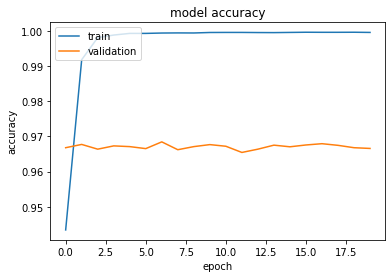

In [30]:
plot_hist(hist)

In [31]:
with strategy.scope():
    model.load_weights('image_rnn_weights_cnn.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 429s 1s/step
              precision    recall  f1-score   support

           0     0.9650    0.9860    0.9754     11443
           1     0.9788    0.9476    0.9630      7804

    accuracy                         0.9704     19247
   macro avg     0.9719    0.9668    0.9692     19247
weighted avg     0.9706    0.9704    0.9704     19247

[[11283   160]
 [  409  7395]]
      TPR       FPR       FNR   ROC AUC
   0.9476    0.0140    0.0524    0.9944


### LSTM

**Text_LSTM**

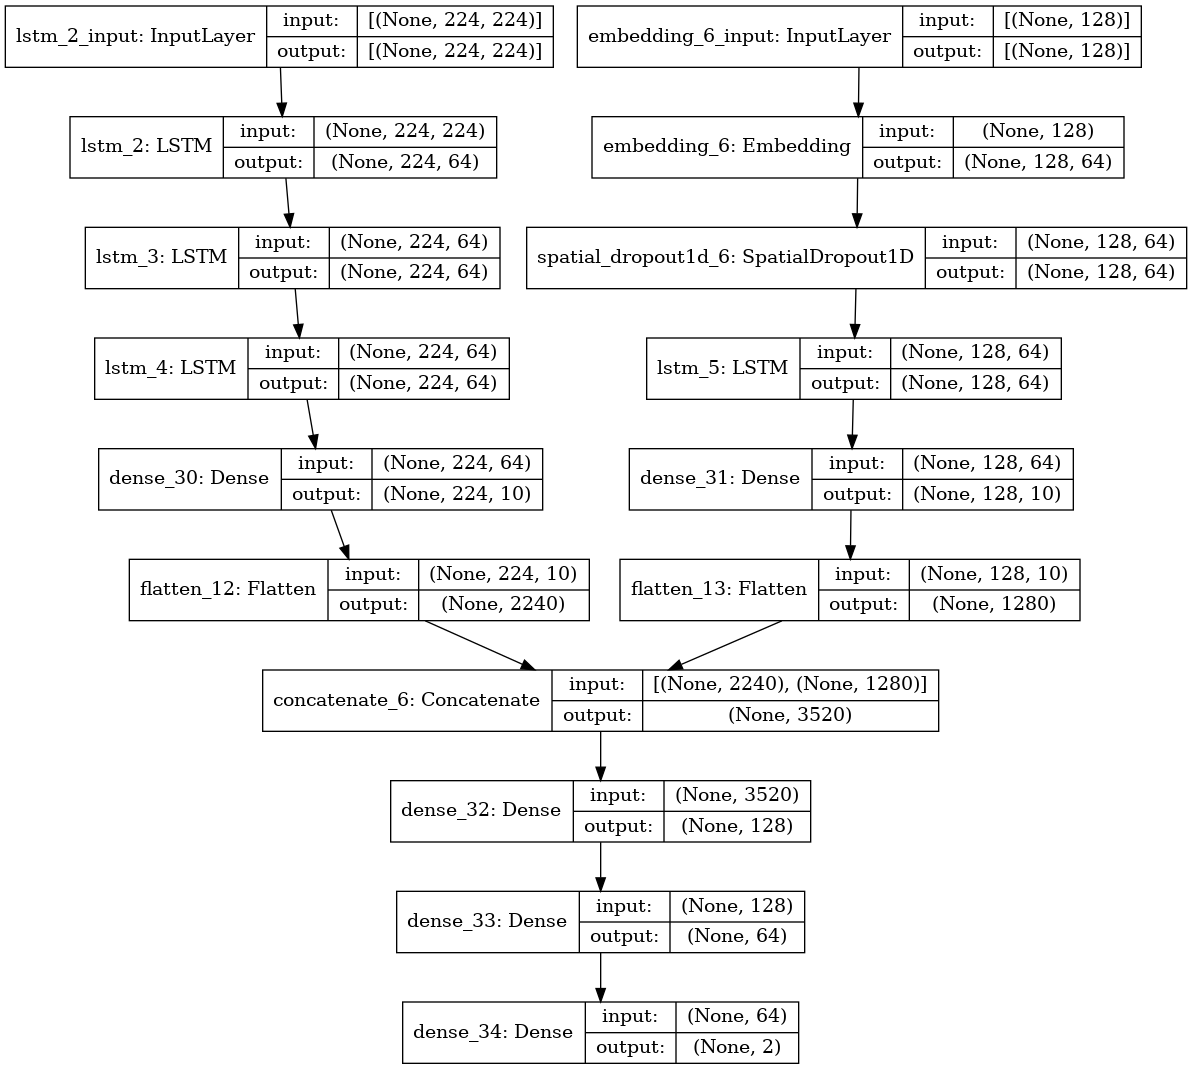

In [32]:
from tensorflow.keras.applications import DenseNet169
with strategy.scope():
    image_model = Sequential()
    image_model.add(L.LSTM(units=64, return_sequences=True, dropout=0.2, 
                                     recurrent_dropout=0.2, input_shape=(IMG_SIZE, IMG_SIZE)))
    image_model.add((L.LSTM(units=64, return_sequences=True, dropout=0.2, 
                                     recurrent_dropout=0.2)))
    image_model.add((L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add((L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [33]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('image_lstm_weights_lstm.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171541632 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 82s - loss: 0.1593 - accuracy: 0.9376 - val_loss: 0.0939 - val_accuracy: 0.9680
Epoch 2/20
902/902 - 61s - loss: 0.0319 - accuracy: 0.9890 - val_loss: 0.0968 - val_accuracy: 0.9686
Epoch 3/20
902/902 - 61s - loss: 0.0086 - accuracy: 0.9974 - val_loss: 0.1216 - val_accuracy: 0.9689
Epoch 4/20
902/902 - 61s - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.1455 - val_accuracy: 0.9675
Epoch 5/20
902/902 - 61s - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.1566 - val_accuracy: 0.9687
Epoch 6/20
902/902 - 61s - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.1972 - val_accuracy: 0.9667
Epoch 7/20
902/902 - 62s - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.1715 - val_accuracy: 0.9677
Epoch 8/20
902/902 - 61s - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.1819 - val_accuracy: 0.9690
Epoch 9/20
902/902 - 61s - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.2042 - val_accuracy: 0.9685
Epoch 10/20
902/902 - 61s - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.1945 - val_accuracy: 0.9686


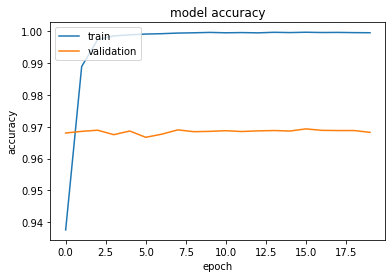

In [34]:
plot_hist(hist)

In [35]:
with strategy.scope():
    model.load_weights('image_lstm_weights_lstm.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 430s 1s/step
              precision    recall  f1-score   support

           0     0.9707    0.9808    0.9757     11443
           1     0.9714    0.9566    0.9639      7804

    accuracy                         0.9710     19247
   macro avg     0.9710    0.9687    0.9698     19247
weighted avg     0.9710    0.9710    0.9709     19247

[[11223   220]
 [  339  7465]]
      TPR       FPR       FNR   ROC AUC
   0.9566    0.0192    0.0434    0.9948


**Text_RNN**

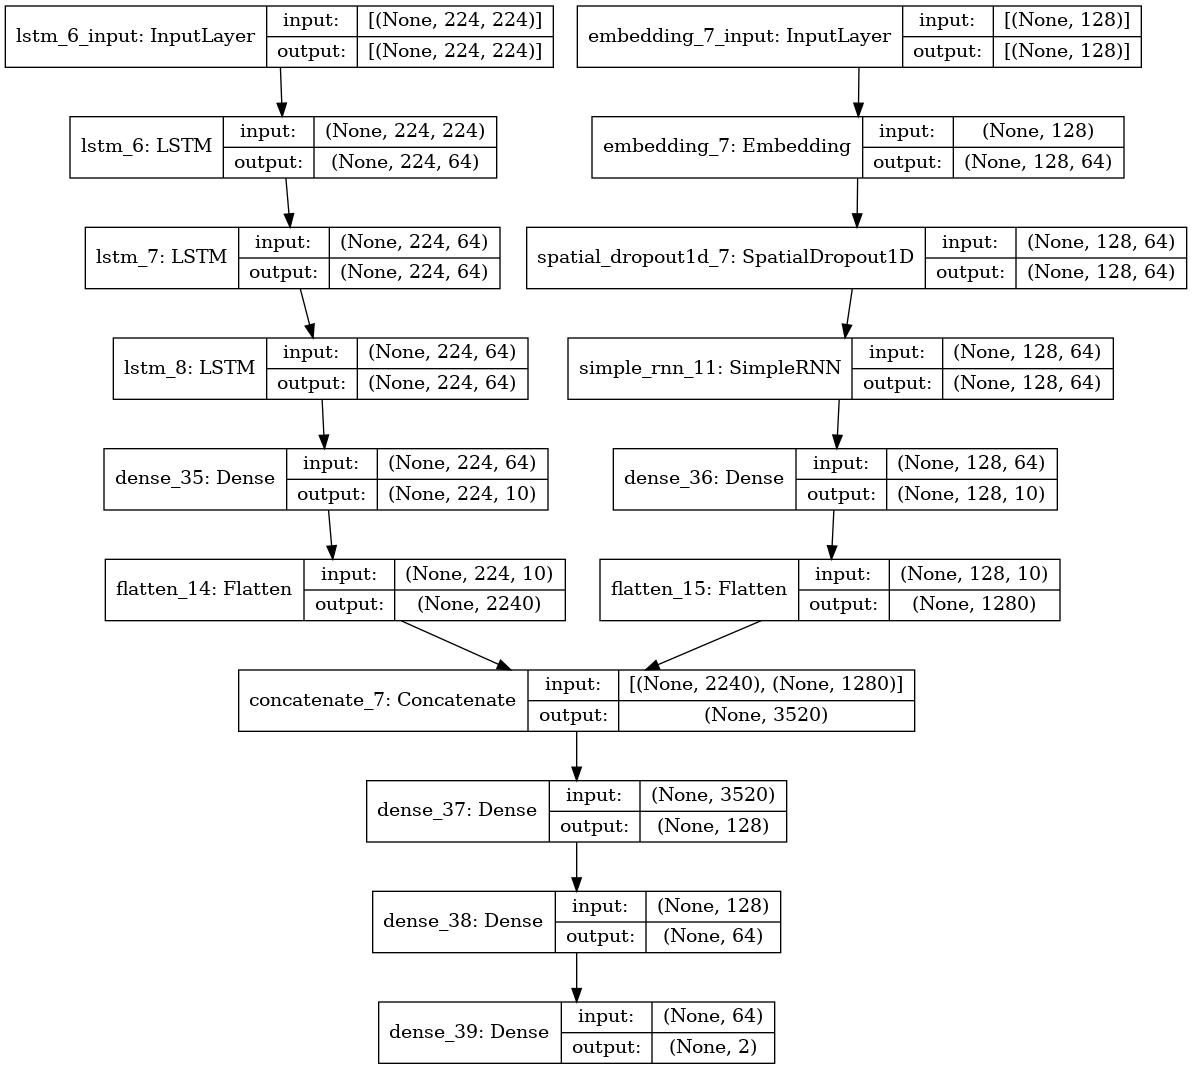

In [36]:
with strategy.scope():
    image_model = Sequential()
    image_model.add(L.LSTM(units=64, return_sequences=True, dropout=0.2, 
                                     recurrent_dropout=0.2, input_shape=(IMG_SIZE, IMG_SIZE)))
    image_model.add((L.LSTM(units=64, return_sequences=True, dropout=0.2, 
                                     recurrent_dropout=0.2)))
    image_model.add((L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add((L.SimpleRNN(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, unroll=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [37]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('image_lstm_weights_rnn.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171541632 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 103s - loss: 0.2997 - accuracy: 0.8681 - val_loss: 0.1276 - val_accuracy: 0.9513
Epoch 2/20
902/902 - 58s - loss: 0.0772 - accuracy: 0.9722 - val_loss: 0.1173 - val_accuracy: 0.9579
Epoch 3/20
902/902 - 59s - loss: 0.0310 - accuracy: 0.9891 - val_loss: 0.1434 - val_accuracy: 0.9534
Epoch 4/20
902/902 - 58s - loss: 0.0179 - accuracy: 0.9939 - val_loss: 0.1671 - val_accuracy: 0.9498
Epoch 5/20
902/902 - 58s - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.1734 - val_accuracy: 0.9528
Epoch 6/20
902/902 - 58s - loss: 0.0072 - accuracy: 0.9980 - val_loss: 0.2165 - val_accuracy: 0.9516
Epoch 7/20
902/902 - 58s - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.2146 - val_accuracy: 0.9518
Epoch 8/20
902/902 - 58s - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.2226 - val_accuracy: 0.9547
Epoch 9/20
902/902 - 58s - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.2013 - val_accuracy: 0.9546
Epoch 10/20
902/902 - 58s - loss: 0.0040 - accuracy: 0.9991 - val_loss: 0.1887 - val_accuracy: 0.9550

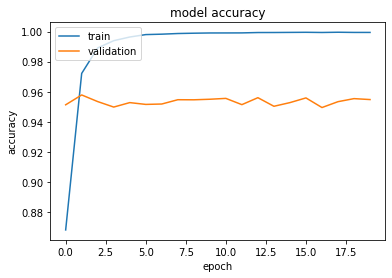

In [38]:
plot_hist(hist)

In [39]:
with strategy.scope():
    model.load_weights('image_lstm_weights_rnn.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 446s 1s/step
              precision    recall  f1-score   support

           0     0.9577    0.9776    0.9676     11443
           1     0.9662    0.9367    0.9512      7804

    accuracy                         0.9610     19247
   macro avg     0.9619    0.9572    0.9594     19247
weighted avg     0.9611    0.9610    0.9609     19247

[[11187   256]
 [  494  7310]]
      TPR       FPR       FNR   ROC AUC
   0.9367    0.0224    0.0633    0.9923


**Text_CNN**

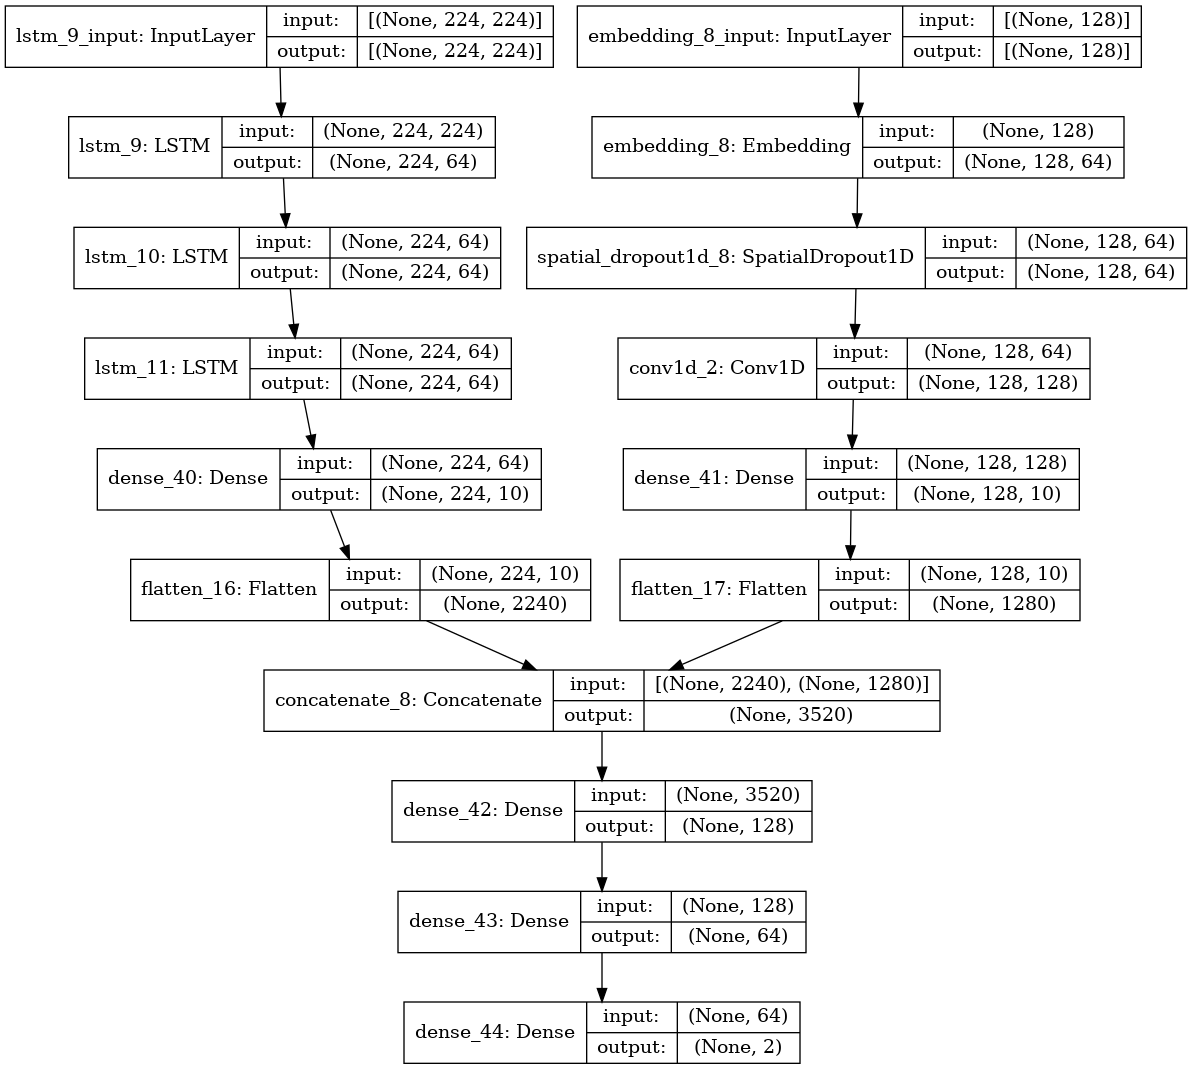

In [40]:
with strategy.scope():
    image_model = Sequential()
    image_model.add(L.LSTM(units=64, return_sequences=True, dropout=0.2, 
                                     recurrent_dropout=0.2, input_shape=(IMG_SIZE, IMG_SIZE)))
    image_model.add((L.LSTM(units=64, return_sequences=True, dropout=0.2, 
                                     recurrent_dropout=0.2)))
    image_model.add((L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Conv1D(128, 5, padding="same"))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [41]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('image_lstm_weights_cnn.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171541632 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 79s - loss: 0.1622 - accuracy: 0.9349 - val_loss: 0.0924 - val_accuracy: 0.9674
Epoch 2/20
902/902 - 57s - loss: 0.0258 - accuracy: 0.9920 - val_loss: 0.1114 - val_accuracy: 0.9665
Epoch 3/20
902/902 - 57s - loss: 0.0053 - accuracy: 0.9987 - val_loss: 0.1351 - val_accuracy: 0.9667
Epoch 4/20
902/902 - 57s - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.1538 - val_accuracy: 0.9671
Epoch 5/20
902/902 - 57s - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.1753 - val_accuracy: 0.9656
Epoch 6/20
902/902 - 57s - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.2174 - val_accuracy: 0.9632
Epoch 7/20
902/902 - 57s - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.1911 - val_accuracy: 0.9662
Epoch 8/20
902/902 - 57s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.1891 - val_accuracy: 0.9663
Epoch 9/20
902/902 - 57s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.2032 - val_accuracy: 0.9660
Epoch 10/20
902/902 - 57s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.2395 - val_accuracy: 0.9645


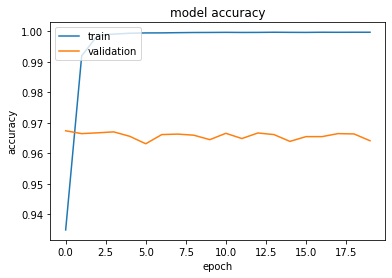

In [42]:
plot_hist(hist)

In [43]:
with strategy.scope():
    model.load_weights('image_lstm_weights_cnn.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 434s 1s/step
              precision    recall  f1-score   support

           0     0.9661    0.9851    0.9755     11443
           1     0.9774    0.9493    0.9631      7804

    accuracy                         0.9705     19247
   macro avg     0.9717    0.9672    0.9693     19247
weighted avg     0.9707    0.9705    0.9705     19247

[[11272   171]
 [  396  7408]]
      TPR       FPR       FNR   ROC AUC
   0.9493    0.0149    0.0507    0.9944
